# Introduction

This notebook was created by Rohit Satija (rsatija@berkeley.edu) and is part of a series of classification algorithms used in the steaming-hot project for the May 2021 Erdős Institute Data Science BootCamp

# Data 

In [8]:
#For data manipulation
import pandas as pd
import numpy as np

#For plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [9]:
data = pd.read_csv('AllData.csv')  # This csv file contains cleaned data of ~10,000 games inlcuding various features
                                   # and mean_player count in the column 'mean'
data = data[data['mean']>1]        # We discard games with mean_player<1 as these represent suspicious games that
                                   # not even the game developer plays
data.shape

(8093, 81)

In [10]:
#Drop columns that are not needed for classification, e.g. Name, App_id, etc
proc_data = data.drop(['App_id','Name','ReleaseDate','Metacritic','SteamSpyOwners', 'SteamSpyOwnersVariance',
                      'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency','SupportEmail', 
                      'SupportURL', 'AboutText','Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice',
                      'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews','RecommendationCount',
                      'SupportedLanguages', 'Website', 'PCMinReqsText', 'PCRecReqsText',
                      'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText','MacRecReqsText',
                      'SteamSpyOwnersNew', 'peak_max', 'peak_mean', 'max'],axis=1)

In [11]:
#This code creates a column called "grade" that one-hot encodes the mean_player count based on popularity
def create_grades(count):
#Return 1 if avg_players>100 and 0 if avg_players<5
        if 100<=count:   
            return 1
        elif count<5:
            return 0
#Return -1 if 5<avg_players<100 in the middle category
        else:
            return -1

proc_data['grade']=proc_data['mean'].apply(create_grades)

#Drop games in the middle category
data_for_classification=proc_data[(proc_data['grade']==0)|(proc_data['grade']==1)]

In [12]:
#Design matrix containing all features
X=data_for_classification.drop(['mean','grade'],axis=1).copy()
X=X.astype(float)

#Target variable: Popularity Grade
y=data_for_classification['grade'].copy()

# Model

In [16]:
#For modeling
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

#For performance measurement
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#For ugly warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
#Create a train-test split of the design matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y,                
                                                    test_size=0.25,    #75-25 split
                                                    random_state = 42, #Random seed for reproducibility
                                                    shuffle=True,      #Shuffle the data before split
                                                    stratify=y)        #Stratify on the target variable to prevent
                                                                       #class imbalance

In [18]:
#The following code runs a 5-fold stratified cross-validation to optimize the cutoff value
#in the Support Vector Classifier routine

#Create a kfold object
kfold = StratifiedKFold(5,shuffle = True,random_state = 42)

#Define the range of cutoffs to search for
cutoffs = np.arange(0,1,.01)

#Create arrays for accuracy_score, precision_score, recall_score, and f1_score
accs = np.zeros((5,len(cutoffs)))
prec = np.zeros((5,len(cutoffs)))
recs = np.zeros((5,len(cutoffs)))
f1s = np.zeros((5,len(cutoffs)))

#Create a model object
svc = SVC(probability=True)

#This is to keep track of the train test split
i = 0

for train_index, test_index in kfold.split(X_train,y_train):
    
    # Get the cv train test split
    X_train_train, X_train_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]
    for j in range(len(cutoffs)):
        
        #Fit the model
        svc_clone = clone(svc)
        svc_clone.fit(X_train_train,y_train_train)
        
        #Predict
        probs = svc_clone.predict_proba(X_train_test)[:,1]
        y_pred = 1*(probs > cutoffs[j])
        
        #Measure accuracy, precision, recall, f1
        accs[i,j] = accuracy_score(y_train_test,y_pred)
        prec[i,j] = precision_score(y_train_test,y_pred)
        recs[i,j] = recall_score(y_train_test,y_pred)
        f1s[i,j] = f1_score(y_train_test,y_pred)

    i=i+1

# Result

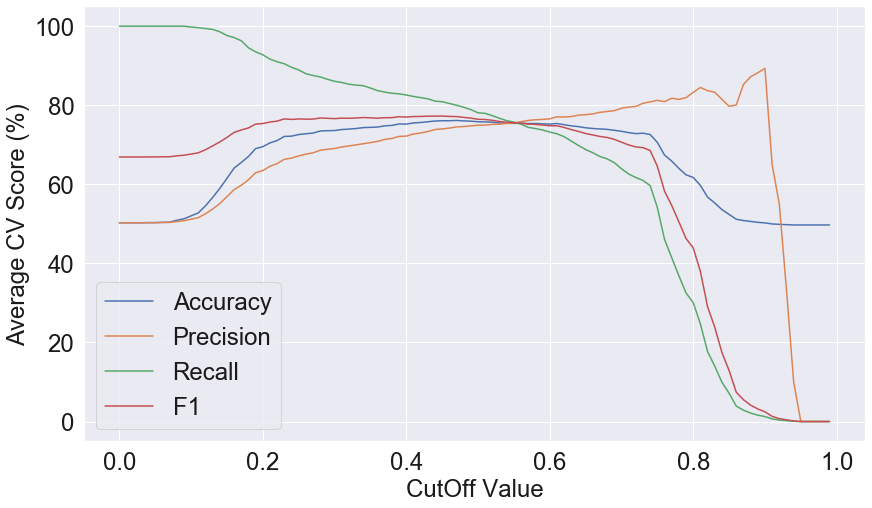

In [20]:
#Plot the result
plt.figure(figsize=(14,8))
fontsize=24
fontcolor='k'

plt.plot(cutoffs, 100*np.mean(accs, axis=0),label='Accuracy')
plt.plot(cutoffs, 100*np.mean(prec, axis=0),label='Precision')
plt.plot(cutoffs, 100*np.mean(recs, axis=0),label='Recall')
plt.plot(cutoffs, 100*np.mean(f1s, axis=0),label='F1')

plt.xlabel("CutOff Value", fontsize=fontsize,color=fontcolor)
plt.ylabel("Average CV Score (%)", fontsize=fontsize,color=fontcolor)

plt.setp(plt.legend(fontsize=fontsize).get_texts(), color=fontcolor)
plt.xticks(fontsize=fontsize,color=fontcolor)
plt.yticks(fontsize=fontsize,color=fontcolor)
plt.show()

In [21]:
print("The cutoff with highest mean CV accuracy was",
         cutoffs[np.argmax(np.mean(accs,axis=0))])
print("The cutoff with highest mean CV precision was",
         cutoffs[np.argmax(np.mean(prec,axis=0))])
print("The cutoff with highest mean CV recall was",
         cutoffs[np.argmax(np.mean(recs,axis=0))])
print("The cutoff with highest mean CV F1 score was",
         cutoffs[np.argmax(np.mean(f1s,axis=0))])

The cutoff with highest mean CV accuracy was 0.47000000000000003
The cutoff with highest mean CV precision was 0.9
The cutoff with highest mean CV recall was 0.0
The cutoff with highest mean CV F1 score was 0.45


Cutoff around 0.45 should give a good result. 

In [22]:
#Let us now train our validated model with cutoff=0.45 on the full training set and calculate performance on 
#test set
svc = SVC(probability=True)

svc.fit(X_train,y_train)
probs = svc.predict_proba(X_test)[:,1]

#Choose cutoff with highest training set accuracy
y_pred = 1*(probs > cutoffs[np.argmax(np.mean(f1s,axis=0))])

print('test accuracy:',np.round(100*accuracy_score(y_test,y_pred),2))
print('test precision:',np.round(100*precision_score(y_test,y_pred),2))
print('test recall:',np.round(100*recall_score(y_test,y_pred),2))
print('test f1-score:',np.round(100*f1_score(y_test,y_pred),2))

test accuracy: 75.78
test precision: 73.45
test recall: 81.24
test f1-score: 77.15


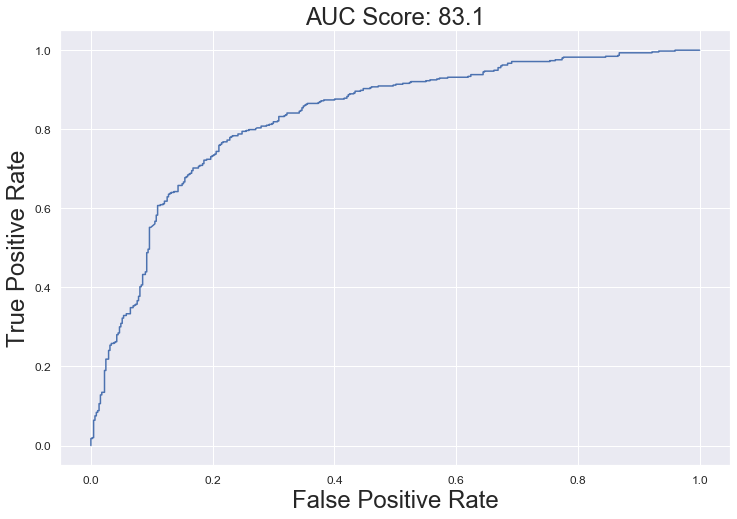

In [23]:
#Plot the ROC curve and calculate the final AUC score on the test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = svc.predict_proba(X_test)

fpr,tpr,cutoffs = roc_curve(y_test,probs[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr,tpr)

plt.title("AUC Score: "+str(np.round(100*roc_auc_score(y_test,probs[:,1]),2)),fontsize=fontsize)
plt.xlabel("False Positive Rate",fontsize=fontsize)
plt.ylabel("True Positive Rate",fontsize=fontsize)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

__That's all folks!__